### Анализ результатов АБ-теста
В данном задании вам нужно будет проанализировать АБ  тест,  проведенный на реальных пользователях Яндекса.
- Подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control)  и тестовой (exp)  группами
- Определить характер этих изменений и практическую значимость вводимого изменения
- Понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)

### Описание  данных:
- userID:  уникальный идентификатор пользователя
- browser:  браузер, который использовал userID
- slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control  = видел неизменную страницу)
- n_clicks: количество кликов, которые пользоваль совершил за n_queries
- n_queries: количество запросов, который совершил userID, пользуясь браузером browser
- n_nonclk_queries: количество запросов пользователя, в которых  им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных  уникальным является сочетание userID и browser.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import scipy 

from scipy import stats

sns.set_style('darkgrid')

In [2]:
cd C:\Users\vlad\Machine_Learning\Yandex Specialization\4. Statistics for Data Analysis\week 4\data

C:\Users\vlad\Machine_Learning\Yandex Specialization\4. Statistics for Data Analysis\week 4\data


In [3]:
# Загрузка данных 
data = pd.read_csv('ab_browser_test.csv')
data

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
...,...,...,...,...,...,...
566129,603133,Browser #14,control,1,2,1
566130,603134,Browser #2,exp,4,2,0
566131,603135,Browser #4,control,0,1,1
566132,603136,Browser #4,control,2,3,1


In [4]:
# Отберем группы 
exp_group = data[data['slot'] == 'exp']
control_group = data[data['slot'] == 'control']

print('Exp Group Size: ', exp_group.shape[0])
print('Control Group Size: ', control_group.shape[0])

Exp Group Size:  281580
Control Group Size:  284554


### Задание 1 
Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы. 

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите  до третьего знака после точки. 

In [5]:
res = ((exp_group['n_clicks'].sum()/control_group['n_clicks'].sum())-1)*100
print('%.3f' %res)

1.614


### Задание 2
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения:
- 95% доверительный интервал для разности медиан не  содержит ноль, похоже, медианы отличаются статистически значимо
- 95% доверительный интервал для разности медиан содержит ноль, похоже, медианы существенно не отличаются
- Применение bootstrap на выборках такого большого размера неправомерно, потому что bootstrap делает псведовыборки с возвращениями, а с ростом объема исходной выборки  псведовыборки с возвращениями становятся более похожими на псведовыборки без возвращения
- 95% доверительный интервал для разности средних не  содержит ноль, похоже, средние отличаются статистически значимо
- 95% доверительный интервал для разности средних содержит ноль, похоже, средние существенно не отличаются

n_clicks Median (Exp Group):  5.0
n_clicks Median (Control Group):  4.0


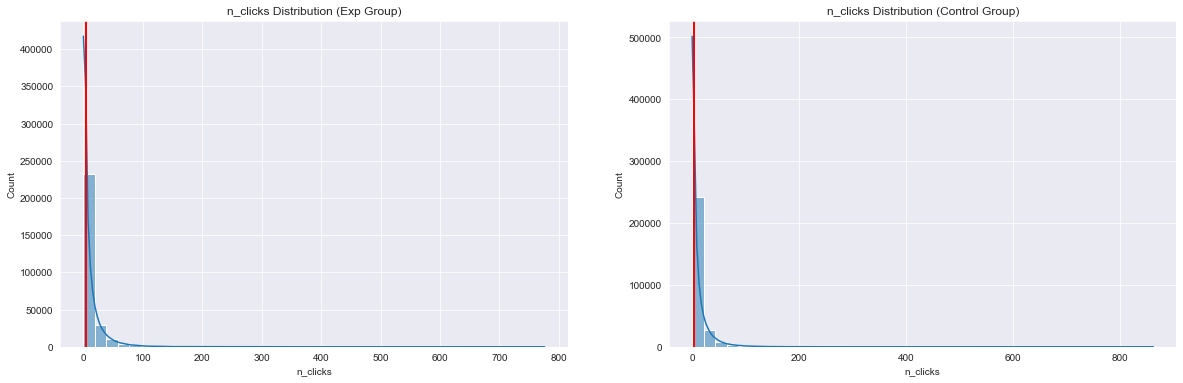

In [6]:
# Отберем медианы в группах 
median_exp = exp_group['n_clicks'].median()
median_control = control_group['n_clicks'].median()

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.histplot(exp_group['n_clicks'], bins=40, kde=True)
plt.axvline(median_exp, color='r', linewidth=2)
plt.title('n_clicks Distribution (Exp Group)')

plt.subplot(1,2,2)
sns.histplot(control_group['n_clicks'], bins=40, kde=True)
plt.axvline(median_control, color='r', linewidth=2)
plt.title('n_clicks Distribution (Control Group)');

print('n_clicks Median (Exp Group): ', median_exp)
print('n_clicks Median (Control Group): ', median_control)

In [7]:
# Определим ряд функций для получения псевдовыборок на основе бутстрепа и получение ДИ
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

# Получим псевдовыборки из медиан для каждой группы 
bootstrap_medians_exp = list(map(np.median, get_bootstrap_samples(exp_group['n_clicks'].values, 1000)))
bootstrap_medians_control = list(map(np.median, get_bootstrap_samples(control_group['n_clicks'].values, 1000)))

# Получим псевдовыборки из средних для каждой группы 
bootstrap_means_exp = list(map(np.mean, get_bootstrap_samples(exp_group['n_clicks'].values, 1000)))
bootstrap_means_control = list(map(np.mean, get_bootstrap_samples(control_group['n_clicks'].values, 1000)))

# Получим ДИ для полученных псевдовыборок (Медианы)
print("95% Сonfidence Interval for Medians (Exp Group):",  stat_intervals(bootstrap_medians_exp))
print("95% Confidence Interval for Medians (Control Group):",  stat_intervals(bootstrap_medians_control))
print()
# Получим ДИ для полученных псевдовыборок (Средине)
print("95% Сonfidence Interval for Means (Exp Group):",  stat_intervals(bootstrap_means_exp))
print("95% Confidence Interval for Means (Control Group):",  stat_intervals(bootstrap_means_control))

95% Сonfidence Interval for Medians (Exp Group): [5. 5.]
95% Confidence Interval for Medians (Control Group): [4. 4.]

95% Сonfidence Interval for Means (Exp Group): [11.51494415 11.659966  ]
95% Confidence Interval for Means (Control Group): [11.20508366 11.35837179]


ДИ интервалы групп средних и медиан не пересекаются, с большой вероятностью группы значимо отличаются друг от друга. Оценим интервально разность медиан и средних для групп, если интервал разности не будет содержать ноль, значит мы правы.

In [8]:
median_diff = list(map(lambda x: x[1] - x[0], zip(bootstrap_medians_control, bootstrap_medians_exp)))
print("95% Confidence Interval For the Difference Between Medians",  stat_intervals(median_diff, 0.05))

mean_diff = list(map(lambda x: x[1] - x[0], zip(bootstrap_means_control, bootstrap_means_exp)))
print("95% Confidence Interval For the Difference Between Means",  stat_intervals(mean_diff, 0.05))

95% Confidence Interval For the Difference Between Medians [1. 1.]
95% Confidence Interval For the Difference Between Means [0.20412716 0.41665794]


ДИ для разностей не содержит ноль, группы значимо отличаются друг от друга. Ответ: 1,4

### Задание 3
Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и  значимым статистически. Последнее утверждение нуждается в дополнительной проверке. 

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

- Для проверки гипотезы о равенстве средних категорически нельзя использовать t-критерий Стьюдента ни при каком размере выборки, потому что количество кликов, которые мы исследуем, больше походят на распределение Пуассона, которое сильно отличается от нормального. 
- Все ответы неверны
- Используя центральную предельную теорему, мы можем заключить, что с ростом объема выборки любое исследуемое распределение, становится похожим на нормальное, а значит, учитывая большой объем нашей выборки, оптимальным критерием  в нашей задаче будет z-критерий.  
- Для проверки гипотезы о равенстве средних в данной задаче можно использовать только параметрические критерии, потому что непараметрические, как известно, с увеличением размера выборки могут давать непредсказуемые результаты в силу случайности в определении их нулевого распределения. 
- Гипотезу о равенстве средних между двумя выборками можно проверить с помощью построения доверительного интервала для среднего объединенной выборки, потому что в силу большого объема выборки этот интервал будет очень точным, и мы сможем надежно оценить необходимый доверительный интервал

Ответ: 2

### Задание 4 
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных. Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных, чтобы дпредположения t-критерия выполнялись необходимо:

- $X$  —  среднее значение в выборке было распределено нормально N(μ,σ2/n)
- $n/σ2*S2$  — несмещенная оценка дисперсии c масштабирующим коэффициентом была распределена по хи-квадрат  c n−1 степенями свободы  χ2(n−1) 

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными  в рамках данного вопроса.


**Важно** для получения одинаковых ответов нужно:
- ```np.random.seed(0)```
- ```n_samples = 500```

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого:
- 1) Получите из данных n_boot_samples  псевдовыборок. 

In [9]:
np.random.seed(0)
n_samples = 500

n_boot_samples = get_bootstrap_samples(control_group['n_clicks'].values, n_samples)

- 2) По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)

In [10]:
means = n_boot_samples.mean(axis=1)
control_boot_chi_squared  = np.var(n_boot_samples, axis=1)

- 3) Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения

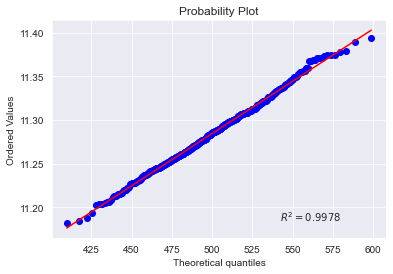

In [11]:
scipy.stats.probplot(means, dist="chi2", sparams=(n_samples-1), plot=plt, rvalue=True);

- 4) Для получившегося вектора  сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot 

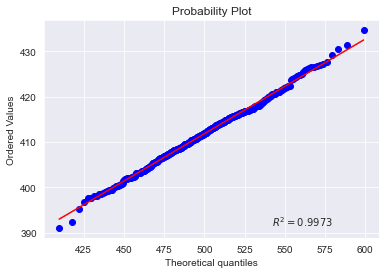

In [12]:
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n_samples-1), plot=plt, rvalue=True);

В качестве ответа отметьте верные утвердения о значениях  ```R2``` при отображении qq-графиков:
-  Одно c графика для среднего
- Одно с графика для выборочной суммы квадратов отклонения от выборочной суммы


- $R2$ для выборочного среднего получился меньше, чем  0.99
- $R2$ для выборочного среднего получился больше, чем  0.99
- $R2$ для выборочной суммы квадратов отклонения от выборочной суммы получился меньше, чем 0.99
- $R2$ для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99

Ответ: 2,4

### Задание 5
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control  и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю  соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы:
- Критерий Манна-Уитни в данной задаче применять нельзя, поэтому вопрос о достигаемом уровне значимости некорректен
- Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между  двумя выборками
- $p-value < 0.01$  поэтому можно сказать, что отличия незначительны на уровне доверия 0.05
- Согласно полученному значению p-value,  мы вынуждены принять нулевую гипотезу

In [13]:
# Отберем группы 
control_user_clicks = control_group.groupby('userID')['n_clicks'].sum()
exp_user_clicks = exp_group.groupby('userID')['n_clicks'].sum()

n_clicks Median (Exp Group):  11.589351572215314
n_clicks Median (Control Group):  11.287332273762974


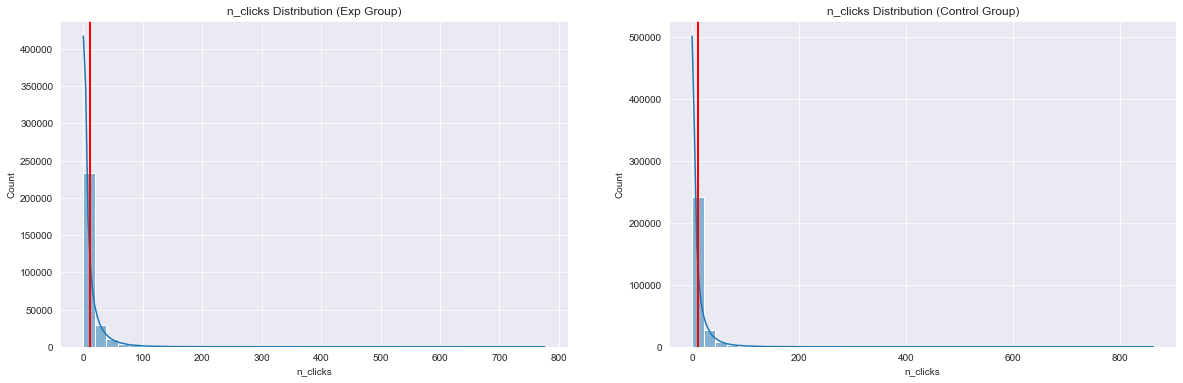

In [14]:
# Отберем средние в группах  
control_user_clicks_means = control_user_clicks.mean()
exp_user_clicks_means = exp_user_clicks.mean()

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.histplot(exp_user_clicks, bins=40, kde=True)
plt.axvline(exp_user_clicks_means, color='r', linewidth=2)
plt.title('n_clicks Distribution (Exp Group)')

plt.subplot(1,2,2)
sns.histplot(control_user_clicks, bins=40, kde=True)
plt.axvline(control_user_clicks_means, color='r', linewidth=2)
plt.title('n_clicks Distribution (Control Group)');

print('n_clicks Median (Exp Group): ', exp_user_clicks_means)
print('n_clicks Median (Control Group): ', control_user_clicks_means)

In [15]:
# Критерий Манна-Уитни
stats.mannwhitneyu(control_user_clicks, exp_user_clicks)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Обнаружены значимые различия между группами

### Задание 6
Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с ```alpha=0.05```

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [16]:
unique_browsers = data['browser'].unique()

p_values = []
for browser in unique_browsers:
    exp = exp_group[exp_group['browser'] == browser]
    control = control_group[control_group['browser'] == browser]
    p_values.append(stats.mannwhitneyu(exp['n_clicks'], control['n_clicks']).pvalue)
    
import statsmodels.stats.multitest as smm
test_res = smm.multipletests(p_values, alpha=0.05/6, method='holm')
print('Number of Insignificant p-values: ', (~test_res[0]).sum())

Number of Insignificant p-values:  5


### Задание 7
Для каждого браузера в каждой из двух групп (control  и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений  n_nonclk_queries  на сумму значений  n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче  проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения:

- По всем браузерам мы видим незначительное уменьшение доли некликнутых запросов, поэтому делаем вывод о том, что тестируемое изменение приносит больше вреда, чем пользы.

- По одному из браузеров мы видим значительное уменьшение доли некликнутых запросов, поэтому уже только на этом основании тестируемое изменение можно рекомендовать к применению для всех пользователей. 

- С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.

- Тестируемое изменение можно предложить к внедрению только на тот сегмент пользователей, где локализуется изменение, то есть для того браузера, для которого  доля некликнутых запросов уменьшилась больше всего. Для прочих браузеров мы не обладаем никакой информацией относительно влияния тестируемого изменения на поведение пользователей. 

In [17]:
exp_perc = []
cntr_perc = []
for browser in unique_browsers:
    exp = exp_group[exp_group['browser'] == browser]
    control = control_group[control_group['browser'] == browser]
    per_exp = (exp['n_nonclk_queries'].sum()/(exp['n_queries']).sum())*100
    per_cntr = (control['n_nonclk_queries'].sum()/(control['n_queries']).sum())*100
    
    exp_perc.append(per_exp)
    cntr_perc.append(per_cntr)

In [18]:
print(exp_perc)
print(cntr_perc)

[44.982746948554706, 45.14294190358467, 43.755617361273295, 36.93741284866483, 38.97737648371716, 39.85394721969546]
[45.96274717919465, 46.97092963514274, 57.59041136008114, 36.29936674628208, 40.540484743383296, 40.593976593513354]


Ответы: